In [1]:
import chess
import chess.svg
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
import os
from IPython.display import display, SVG, clear_output
import chess.pgn
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN, A2C 
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# Setting up our device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Encoding

In [3]:
def board_to_tensor(board): # Converting the board to 896D tensor
    planes = np.zeros((8, 8, 14), dtype=np.float32) # 8x8 board and 12 unique + 2 castling
    piece_map = {chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
                 chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5}
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color_offset = 0 if piece.color == chess.WHITE else 6
            piece_idx = piece_map[piece.piece_type] + color_offset
            row, col = divmod(square, 8)
            planes[row, col, piece_idx] = 1
    planes[:, :, 12] = 1 if board.has_kingside_castling_rights(chess.WHITE) else 0
    planes[:, :, 13] = 1 if board.has_queenside_castling_rights(chess.WHITE) else 0
    return planes.flatten()
    # Note: returning Numpy array instead of tensor since we are using Gym

# Custom Chess environment

In [4]:
class ChessEnv(gym.Env):  
    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()
        self.action_space = spaces.Discrete(4096)  
        self.observation_space = spaces.Box(low=0, high=1, shape=(896,), dtype=np.float32)
        self.max_steps = 1000
        self.step_count = 0

    def reset(self, seed=None, options=None):  
        super().reset(seed=seed)  
        self.board.reset()
        self.step_count = 0
        return self._get_obs(), {}  

    def step(self, action):
        legal_moves = list(self.board.legal_moves)
        if not legal_moves:
            return self._get_obs(), -1, True, False, {}  
        move = self._index_to_move(action, legal_moves)
        if move in legal_moves:
            self.board.push(move)
        self.step_count += 1
        reward = 1 if self.board.is_checkmate() else 0.1 if self.board.is_capture(self.board.peek()) else 0
        done = self.board.is_game_over() or self.step_count >= self.max_steps
        truncated = self.step_count >= self.max_steps  
        return self._get_obs(), reward, done, truncated, {}

    def render(self, mode="human"):
        display(SVG(chess.svg.board(self.board, size=400)))

    def _get_obs(self):
        return board_to_tensor(self.board)

    def _index_to_move(self, idx, legal_moves):
        return legal_moves[idx % len(legal_moves)]  

In [5]:
env = ChessEnv()
check_env(env)
print("ENV is compatible with SB3")

ENV is compatible with SB3


# Reading Dataset

In [6]:
dataset = []
data_dir = "../data"
LIMIT = 117
if os.path.exists(data_dir):
    for filename in os.listdir(data_dir):
        if filename.endswith(".pgn"):
            filepath = os.path.join(data_dir, filename)
            with open(filepath, 'r') as pgn_file:
                for i in range(LIMIT):
                    game = chess.pgn.read_game(pgn_file)
                    # print(pgn_file)
                    if game is None:
                        break
                    board = chess.Board()
                    game_data = {'states': [], 'moves': [], 'result': None}
                    for move in game.mainline_moves():
                        state = board_to_tensor(board)
                        game_data['states'].append(state)
                        game_data['moves'].append(move)
                        board.push(move)
                    game_data['result'] = game.headers.get("Result", "*")
                    dataset.append(game_data)
    print(f"Loaded {len(dataset)} games from PGN files in '{data_dir}'")
else:
    print(f"Directory '{data_dir}' not found. Dataset remains empty.")

Loaded 8568 games from PGN files in '../data'


# Feature extracting for SB3

In [7]:
# Custom feature extractor for SB3
class ChessFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super(ChessFeatureExtractor, self).__init__(observation_space, features_dim)
        self.net = nn.Sequential(
            nn.Linear(896, features_dim),
            nn.ReLU(),
            nn.Linear(features_dim, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        return self.net(observations)

dqn_policy_kwargs = dict(
    features_extractor_class=ChessFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=[128, 64]
)

actor_critic_policy_kwargs = dict(
    features_extractor_class=ChessFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=[dict(pi=[128, 64], vf=[128, 64])]
)

In [8]:
# SB3 Agents
env = ChessEnv()
agents = {
    "DQN": DQN("MlpPolicy", env, policy_kwargs=dqn_policy_kwargs, learning_rate=0.0001, buffer_size=10000, verbose=1, device="cuda"),
    "PPO": PPO("MlpPolicy", env, policy_kwargs=actor_critic_policy_kwargs, learning_rate=0.0003, n_steps=2048, verbose=1, device="cuda"),
    "A2C": A2C("MlpPolicy", env, policy_kwargs=actor_critic_policy_kwargs, learning_rate=0.0001, verbose=1, device="cuda")
}
# Training loop
save_dir = "./chess_models_sb3"
os.makedirs(save_dir, exist_ok=True)
num_timesteps = 117000

for name, agent in agents.items():
    print(f"Training {name}")
    if name != "AlphaZero":
        agent.learn(total_timesteps=num_timesteps)
        model_path = os.path.join(save_dir, f"{name.lower()}_model.zip")
        agent.save(model_path)
        print(f"Saved {name} model to {model_path}")
    else:
        agent.train(num_episodes=100)
        print(f"AlphaZero trained with MCTS (no model saved)")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training DQN
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 334      |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11626    |
|    time_elapsed     | 0        |
|    total_timesteps  | 1338     |
----------------------------------


G:\ml\venv\Lib\site-packages\stable_baselines3\common\policies.py:460: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 30.4     |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 11539    |
|    time_elapsed     | 0        |
|    total_timesteps  | 2401     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | 29.7     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 11545    |
|    time_elapsed     | 0        |
|    total_timesteps  | 3523     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 291      |
|    ep_rew_mean      | 29.4     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes       

In [9]:
loaded_agents = {}
save_dir = "./chess_models_sb3"
env = ChessEnv()
for name in ["DQN", "PPO", "A2C"]:
    model_path = os.path.join(save_dir, f"{name.lower()}_model.zip")
    if os.path.exists(model_path):
        if name == "DQN":
            loaded_agents[name] = DQN.load(model_path, env=env)
        elif name == "PPO":
            loaded_agents[name] = PPO.load(model_path, env=env)
        elif name == "A2C":
            loaded_agents[name] = A2C.load(model_path, env=env)
        print(f"Loaded {name} model from {model_path}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded DQN model from ./chess_models_sb3\dqn_model.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded PPO model from ./chess_models_sb3\ppo_model.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded A2C model from ./chess_models_sb3\a2c_model.zip


G:\ml\venv\Lib\site-packages\stable_baselines3\common\save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_location=device)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded DQN model from ./chess_models_sb3\dqn_model.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded PPO model from ./chess_models_sb3\ppo_model.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded A2C model from ./chess_models_sb3\a2c_model.zip
Initial observation shape: (896,)
Starting game. Enter moves in UCI format (e.g., 'e2e4'). Type 'quit' to exit.


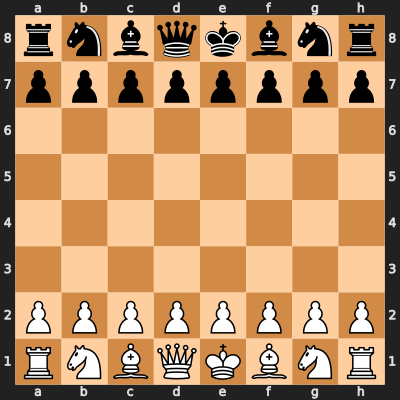


Move 1: Turn = White


Your move:  quit


Received input: quit
Game ended by user.


In [11]:
loaded_agents = {}
for name in ["DQN", "PPO", "A2C"]:
    model_path = os.path.join(save_dir, f"{name.lower()}_model.zip")
    if os.path.exists(model_path):
        if name == "DQN":
            loaded_agents[name] = DQN.load(model_path, env=env)
        elif name == "PPO":
            loaded_agents[name] = PPO.load(model_path, env=env)
        elif name == "A2C":
            loaded_agents[name] = A2C.load(model_path, env=env)
        print(f"Loaded {name} model from {model_path}")

# loaded_agents["AlphaZero"] = alpha_zero

def play_against_agent(agent_name, human_color=chess.WHITE):
    if agent_name not in loaded_agents:
        print(f"No model loaded for {agent_name}")
        return
    
    agent = loaded_agents[agent_name]
    board = chess.Board()
    env = ChessEnv() if agent_name != "AlphaZero" else spiel_env
    
    # Initialize environment and sync board
    if agent_name != "AlphaZero":
        obs, _ = env.reset()
        board = env.board.copy()
        print(f"Initial observation shape: {obs.shape}")
    else:
        time_step = env.reset()
        board = chess.Board(time_step.observations["info"]["state"])
        print(f"Initial OpenSpiel state: {time_step.observations['info']['state']}")
    
    print("Starting game. Enter moves in UCI format (e.g., 'e2e4'). Type 'quit' to exit.")
    display(SVG(chess.svg.board(board, size=400)))
    
    move_count = 0
    while not board.is_game_over():
        move_count += 1
        print(f"\nMove {move_count}: Turn = {'White' if board.turn == chess.WHITE else 'Black'}")
        
        if board.turn == human_color:
            move_input = input("Your move: ").strip()
            print(f"Received input: {move_input}")
            if move_input.lower() == 'quit':
                print("Game ended by user.")
                return
            try:
                move = chess.Move.from_uci(move_input)
                legal_moves = list(board.legal_moves)
                print(f"Legal moves: {[m.uci() for m in legal_moves]}")
                if move in legal_moves:
                    board.push(move)
                    if agent_name != "AlphaZero":
                        env_legal_moves = list(env.board.legal_moves)
                        print(f"Env legal moves: {[m.uci() for m in env_legal_moves]}")
                        action_idx = env_legal_moves.index(move)
                        print(f"Human action index: {action_idx}")
                        obs, reward, terminated, truncated, info = env.step(action_idx)
                        board = env.board.copy()  # Sync after step
                        print(f"After human move: Obs shape={obs.shape}, Reward={reward}, Terminated={terminated}, Truncated={truncated}")
                        if terminated or truncated:
                            print("Game terminated after human move")
                            break
                    clear_output(wait=True)
                    display(SVG(chess.svg.board(board, size=400)))
                else:
                    print("Illegal move. Try again.")
            except ValueError as e:
                print(f"Invalid UCI format or error: {e}. Try again.")
        else:
            if agent_name != "AlphaZero":
                print(f"Predicting action for obs shape: {obs.shape}")
                action, _ = agent.predict(obs, deterministic=True)
                legal_moves = list(board.legal_moves)
                move = env._index_to_move(action, legal_moves)
                print(f"Agent selected action: {action}, Mapped move: {move.uci()}")
                obs, reward, terminated, truncated, info = env.step(action)
                board = env.board.copy()  # Sync after step
                print(f"After agent move: Obs shape={obs.shape}, Reward={reward}, Terminated={terminated}, Truncated={truncated}")
                if terminated or truncated:
                    print("Game terminated after agent move")
                    break
            else:
                print(f"AlphaZero predicting with time_step: {time_step.observations['info']['state']}")
                action = agent.select_action(time_step)
                move_uci = spiel_env.game.action_to_string(action)
                move = chess.Move.from_uci(move_uci)
                print(f"AlphaZero move: {move.uci()}")
                board.push(move)
                time_step = env.step([action])[0]
            clear_output(wait=True)
            display(SVG(chess.svg.board(board, size=400)))
            print(f"{agent_name}'s move: {move.uci()}")
    
    print(f"Game over. Result: {board.result()}")

play_against_agent("PPO", human_color=chess.WHITE)